In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import least_squares

# Step 1: Load the CSV file

In [2]:
data = pd.read_csv('pulse_discharge_test_data.csv', encoding='ISO-8859-1')
data = data[:7850]
data.head()

,TIME,"""VDC""","""AMPS""","""°F""","""VDC"".1","""AMPS"".1","""°F"""
0,7:49:26 AM,26.3467,0.012093,83.8055,26.2096,-0.012426,79.4296
1,7:49:36 AM,26.3484,0.013611,83.8133,26.2070,-0.011908,79.4368
2,7:49:46 AM,26.3477,0.025167,83.7744,26.2091,0.000537,79.3995
3,7:49:56 AM,26.3483,0.030908,83.8188,26.2078,0.011945,79.4607
4,7:50:06 AM,26.3471,0.028649,83.7770,26.2060,0.001907,79.4264


Text(0.5, 1.0, '"°F"')

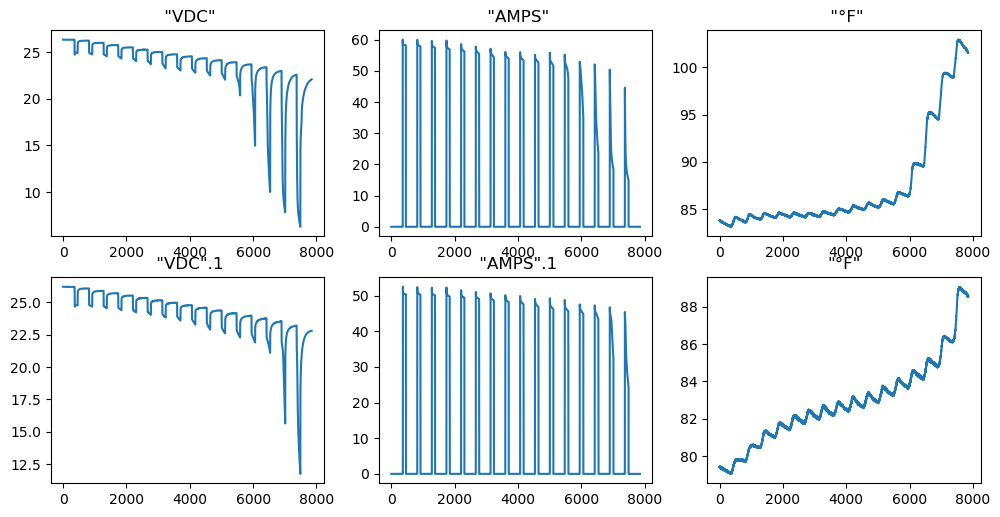

In [3]:
plt.figure(figsize=(12, 6), dpi=100)
plt.subplot(2,3,1)
plt.plot(data[' "VDC"'])
plt.title(' "VDC"')
plt.subplot(2,3,2)
plt.plot(data[' "AMPS"'])
plt.title(' "AMPS"')
plt.subplot(2,3,3)
plt.plot(data[' "°F"'])
plt.title(' "°F"')
plt.subplot(2,3,4)
plt.plot(data[' "VDC".1'])
plt.title(' "VDC".1')
plt.subplot(2,3,5)
plt.plot(data[' "AMPS".1'])
plt.title(' "AMPS".1')
plt.subplot(2,3,6)
plt.plot(data['"°F"'])
plt.title('"°F"')

# Step 2: Split the Data based on Start and Ending of a rest period

In [4]:
def Data_splitter(vec,threshold):
    mask = vec>threshold
    start_id = []
    end_id = []
    state = mask[0]
    for i,v in enumerate(mask):
        if state == v:
            continue
        if state == 0 and v == 1:
            start_id.append(i)
            state = v
        if state == 1 and v == 0:
            end_id.append(i)
            state = v
    return start_id, end_id, mask

[367, 821, 1281, 1742, 2205, 2669, 3134, 3600, 4068, 4536, 5006, 5477, 5949, 6423, 6898, 7374]
[461, 921, 1382, 1845, 2309, 2774, 3240, 3708, 4177, 4646, 5117, 5590, 6063, 6538, 7014, 7491]


<function matplotlib.pyplot.show(*args, **kw)>

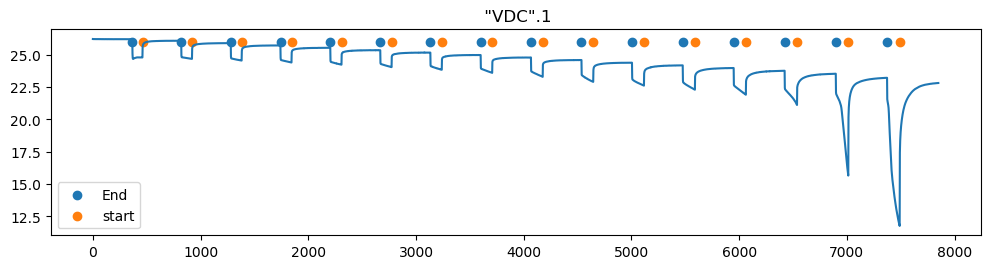

In [5]:
threshold = 1
Endidx1, Strtidx1, mask1 = Data_splitter(data[' "AMPS"'],threshold)

# Start and Ending indices for test 2 

Endidx2, Strtidx2, mask2 = Data_splitter(data[' "AMPS".1'],threshold)
print(Endidx2)
print(Strtidx2)

plt.figure(figsize=(12, 6), dpi=100)
plt.subplot(2,1,1)
plt.plot(data[' "VDC".1'])

yst=26*(np.ones(len(Strtidx2)))
plt.scatter(Endidx2,yst,label='End')
plt.scatter(Strtidx2,yst,label='start')
plt.legend()
plt.title(' "VDC".1')
plt.show

# Step 3 Model and Residual function

In [6]:
def model(params, i):
    ts = 0 
    tr = np.array(range(1,len(i)+1))
    OCV = params[0]
    model = np.zeros((len(tr),))
    model = OCV 
    
    for p in range(1,len(params)-1,2):
        model -= i[ts]*params[p]*np.exp(-tr/params[p+1])
    return model

In [7]:
def residual(params, i, v):
    mdl = model(params, i)
    
    return abs(v-mdl)

## Step 3 Estimate the parameters for Pulse Discharge Test 1

In [8]:
param1=[]
EstParam_data1=[]
All_R0_Test1=[]
for idx in range(len(Strtidx1)-1):
    
    # Initial guesses for OCV, Ra,tau1,R2,Tau2,R3,tau3,....
    ocv=data.iloc[:,1][Endidx1[idx+1]-3] # OCV 
    
    # Estimate Ro
    I_dis=data.iloc[:,2][Strtidx1[idx]-1] # at ts
    vr=data.iloc[:,1][Strtidx1[idx]+5] # at tr
    R0=np.abs(vr/I_dis); # R0
    All_R0_Test1.append(R0)
    
    R1=0.95*(ocv-vr)/I_dis
    R2=R1/2
    R3= R2/2
    R4=R3/2
    
    Tau=0.95*(len(range(Strtidx1[idx]+15,Endidx1[idx+1]-1))) # Tau: 95% of time
    Tau1=Tau/3
    Tau2=Tau1/3
    Tau3= Tau2/3
    Tau4=Tau3/3



    Rn=[R1,R2,R3,R4]
    Taun=[Tau1, Tau2,Tau3,Tau4]

    param1.append(ocv)
    #param1.append(R0)
    est_1rest=[]
    for N_exp in range(0,4):
        param1.append(Rn[N_exp])
        param1.append(Taun[N_exp])
       
        est_1rest.append(least_squares(residual, param1, \
                        args=(np.array(data.iloc[:,2][Strtidx1[idx]:Endidx1[idx+1]]), \
                             np.array(data.iloc[:,1][Strtidx1[idx]:Endidx1[idx+1]])), \
                             bounds = (0, np.inf)))
                             

    param1.clear()
    EstParam_data1.append(est_1rest)
    
    
                 
                 


## Step 3 Plot the Estimated and measured OCV for TEST 1


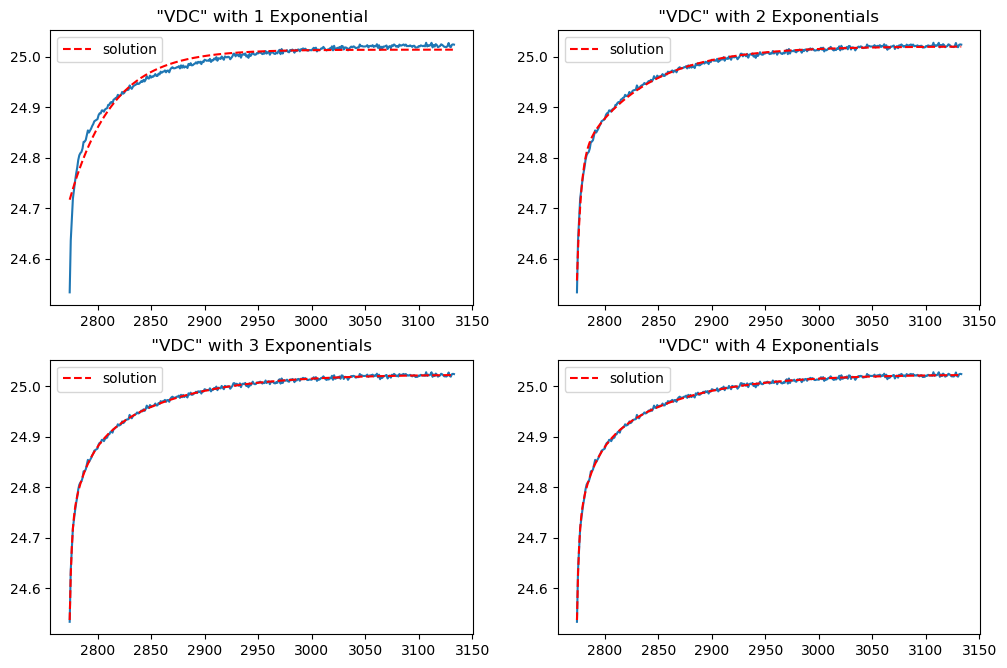

In [9]:
rest_ID=5 ## Choose any number between 0 and 14, as we have 15 total rest period
est_v0 = model(EstParam_data1[rest_ID][0].x, np.array(data.iloc[:,2][Strtidx1[rest_ID]:Endidx1[rest_ID+1]]))
est_v1= model(EstParam_data1[rest_ID][1].x, np.array(data.iloc[:,2][Strtidx1[rest_ID]:Endidx1[rest_ID+1]]))
est_v2 = model(EstParam_data1[rest_ID][2].x, np.array(data.iloc[:,2][Strtidx1[rest_ID]:Endidx1[rest_ID+1]]))
est_v3 = model(EstParam_data1[rest_ID][3].x, np.array(data.iloc[:,2][Strtidx1[rest_ID]:Endidx1[rest_ID+1]]))

plt.figure(figsize=(12, 8), dpi=100)
plt.grid(color='k', linestyle='-', linewidth=2)
plt.subplot(2,2,1)
plt.plot(data[' "VDC"'][Strtidx1[rest_ID]:Endidx1[rest_ID+1]])
plt.title(' "VDC" with 1 Exponential ')
plt.plot(range(Strtidx1[rest_ID],Endidx1[rest_ID+1]),est_v0,'--r',label='solution')
plt.legend()

plt.subplot(2,2,2)
plt.plot(data[' "VDC"'][Strtidx1[rest_ID]:Endidx1[rest_ID+1]])
plt.title(' "VDC" with 2 Exponentials ')
plt.plot(range(Strtidx1[rest_ID],Endidx1[rest_ID+1]),est_v1,'--r',label='solution')
plt.legend()

plt.subplot(2,2,3)
plt.plot(data[' "VDC"'][Strtidx1[rest_ID]:Endidx1[rest_ID+1]])
plt.title(' "VDC" with 3 Exponentials ')
plt.plot(range(Strtidx1[rest_ID],Endidx1[rest_ID+1]),est_v2,'--r',label='solution')
plt.legend()

plt.subplot(2,2,4)
plt.plot(data[' "VDC"'][Strtidx1[rest_ID]:Endidx1[rest_ID+1]])
plt.title(' "VDC" with 4 Exponentials ')
plt.plot(range(Strtidx1[rest_ID],Endidx1[rest_ID+1]),est_v3,'--r',label='solution')
plt.legend()


## step 3 Analysis of Observed residuals for test 1

([<matplotlib.axis.XTick at 0x1c07f0097b8>,
 <a list of 4 Text xticklabel objects>)

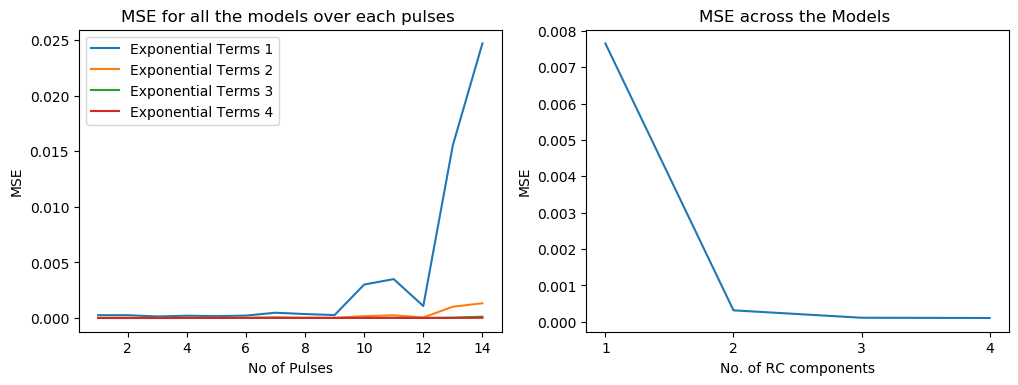

In [10]:
mse_residual=np.zeros((len(Strtidx1)-1,4))
for nn in range(len(Strtidx1)-1):
    volt=  np.array(data.iloc[:,1][Strtidx1[nn]:Endidx1[nn+1]])
    I   =  np.array(data.iloc[:,2][Strtidx1[nn]:Endidx1[nn+1]])
    for xpn in range(4):
        vtemp = residual(EstParam_data1[nn][xpn].x,I,volt)
        v_res=(np.sum(vtemp**2))/len(vtemp)
        mse_residual[nn,xpn]=v_res
    
plt.figure(figsize=(12, 4), dpi=100)
plt.subplot(1,2,1)
for crv in range (0,4):
    plt.plot(range(1,15),mse_residual[0:14,crv],label='Exponential Terms '+ str(crv+1))
    plt.legend()
plt.title('MSE for all the models over each pulses ')
plt.xlabel('No of Pulses')
plt.ylabel('MSE')

plt.subplot(1,2,2)
plt.plot(range(1,5),np.mean(mse_residual,axis=0))
plt.title('MSE across the Models ')
plt.xlabel('No. of RC components')
plt.ylabel('MSE') 
plt.xticks([1,2,3,4])



## Step 3 Estimate battery parameters for Pulse Discharge Test 2

In [11]:
param2=[]
EstParam_data2=[]
All_R0_Test2=[]
for idx in range(len(Strtidx2)-1):
    
    # Initial guesses for OCV, Ra,tau1,R2,Tau2,R3,tau3,....
    ocv=data.iloc[:,4][Endidx2[idx+1]] # OCV 
    
    # Estimate Ro
    I_dis=data.iloc[:,5][Strtidx2[idx]-1] # at ts
    vr   =data.iloc[:,4][Strtidx2[idx]+5] # at tr
    R0=np.abs(vr/I_dis); # R0
    All_R0_Test2.append(R0)
    
    R1=np.abs(0.95*(ocv-vr)/I_dis)
    R2=R1/2
    R3= R2/2
    R4=R3/2
    
    Tau=0.95*(len(range(Strtidx2[idx]+15,Endidx2[idx+1]-1))) # Tau: 95% of time
 
    Tau1=Tau/3
    Tau2=Tau1/3
    Tau3= Tau2/3
    Tau4=Tau3/3



    Rn=[R1,R2,R3,R4]
    Taun=[Tau1, Tau2,Tau3,Tau4]

    param2.append(ocv)
    #param2.append(R0)
    est_1rest=[]
    for N_exp in range(0,4):
        param2.append(Rn[N_exp])
        param2.append(Taun[N_exp])
      
        est_1rest.append(least_squares(residual, param2, \
                        args=(np.array(data.iloc[:,5][Strtidx2[idx]:Endidx2[idx+1]]), \
                             np.array(data.iloc[:,4][Strtidx2[idx]:Endidx2[idx+1]]))))
                             #bounds = (0, np.inf)))
                             
    
    param2.clear()
    EstParam_data2.append(est_1rest)
    
    
                 
                 

C:\Users\Home\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:237: RuntimeWarning: overflow encountered in double_scalars
  ratio = actual_reduction / predicted_reduction


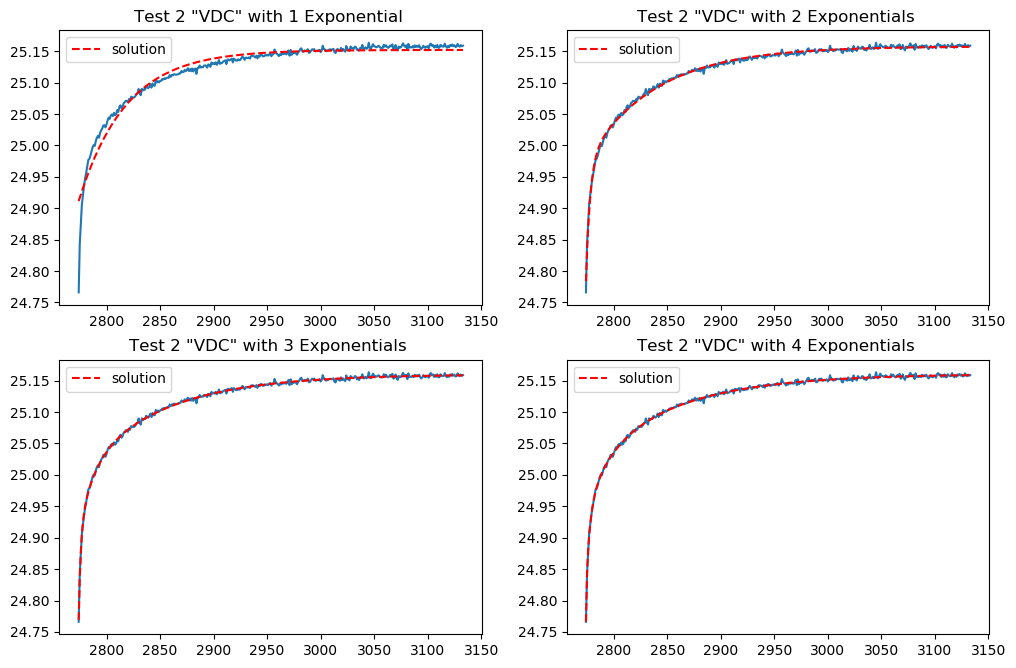

In [12]:
rest_ID=5 ## Choose any number between 0 and 14, as we have 15 total rest period
est2_v0 = model(EstParam_data2[rest_ID][0].x, np.array(data.iloc[:,5][Strtidx2[rest_ID]:Endidx2[rest_ID+1]]))
est2_v1= model(EstParam_data2[rest_ID][1].x, np.array(data.iloc[:,5][Strtidx2[rest_ID]:Endidx2[rest_ID+1]]))
est2_v2 = model(EstParam_data2[rest_ID][2].x, np.array(data.iloc[:,5][Strtidx2[rest_ID]:Endidx2[rest_ID+1]]))
est2_v3 = model(EstParam_data2[rest_ID][3].x, np.array(data.iloc[:,5][Strtidx2[rest_ID]:Endidx2[rest_ID+1]]))

plt.figure(figsize=(12, 8), dpi=100)
plt.grid(color='k', linestyle='-', linewidth=2)
plt.subplot(2,2,1)
plt.plot(data[' "VDC".1'][Strtidx2[rest_ID]:Endidx2[rest_ID+1]])
plt.title('Test 2 "VDC" with 1 Exponential ')
plt.plot(range(Strtidx2[rest_ID],Endidx2[rest_ID+1]),est2_v0,'--r',label='solution')
plt.legend()

plt.subplot(2,2,2)
plt.plot(data[' "VDC".1'][Strtidx2[rest_ID]:Endidx2[rest_ID+1]])
plt.title('Test 2 "VDC" with 2 Exponentials ')
plt.plot(range(Strtidx2[rest_ID],Endidx2[rest_ID+1]),est2_v1,'--r',label='solution')
plt.legend()

plt.subplot(2,2,3)
plt.plot(data[' "VDC".1'][Strtidx2[rest_ID]:Endidx2[rest_ID+1]])
plt.title('Test 2 "VDC" with 3 Exponentials ')
plt.plot(range(Strtidx2[rest_ID],Endidx2[rest_ID+1]),est2_v2,'--r',label='solution')
plt.legend()

plt.subplot(2,2,4)
plt.plot(data[' "VDC".1'][Strtidx2[rest_ID]:Endidx2[rest_ID+1]])
plt.title('Test 2 "VDC" with 4 Exponentials ')
plt.plot(range(Strtidx2[rest_ID],Endidx2[rest_ID+1]),est2_v3,'--r',label='solution')
plt.legend()


## Step 3:  Analysis of Observed Residuals for Test 2

([<matplotlib.axis.XTick at 0x1c07f30a438>,
 <a list of 4 Text xticklabel objects>)

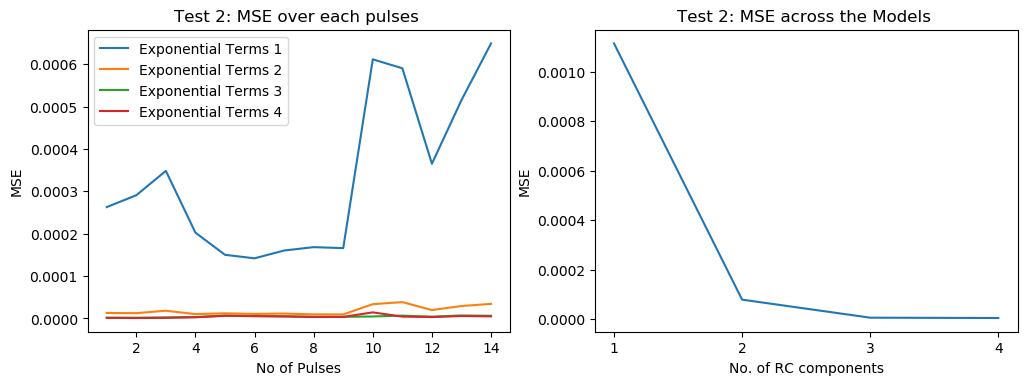

In [13]:
mse_residual=np.zeros((len(Strtidx2)-1,4))
for nn in range(len(Strtidx2)-1):
    volt=  np.array(data.iloc[:,4][Strtidx2[nn]:Endidx2[nn+1]])
    I   =  np.array(data.iloc[:,5][Strtidx2[nn]:Endidx2[nn+1]])
    for xpn in range(4):
        vtemp = residual(EstParam_data2[nn][xpn].x,I,volt)
        v_res=(np.sum(vtemp**2))/len(vtemp)
        mse_residual[nn,xpn]=v_res
    
plt.figure(figsize=(12, 4), dpi=100)
plt.subplot(1,2,1)
for crv in range (0,4):
    plt.plot(range(1,15),mse_residual[0:14,crv],label='Exponential Terms '+ str(crv+1))
    plt.legend()
plt.title('Test 2: MSE over each pulses ')
plt.xlabel('No of Pulses')
plt.ylabel('MSE')

plt.subplot(1,2,2)
plt.plot(range(1,5),np.mean(mse_residual,axis=0))
plt.title('Test 2: MSE across the Models ')
plt.xlabel('No. of RC components')
plt.ylabel('MSE') 
plt.xticks([1,2,3,4])


Text(0.5, 1.0, 'SOC for Test 1 and Test 2')

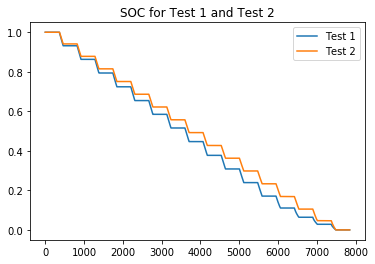

In [14]:
Q1 = sum(data.iloc[:,2])
Q2 = sum(data.iloc[:,5])
t = np.linspace(0,np.array(len(data.iloc[:,2]))-1,np.array(len(data.iloc[:,2])))
SOC_test1 = [1 - sum(data.iloc[:,2][:int(tt)]) / Q1 for tt in t]
SOC_test2 = [1 - sum(data.iloc[:,5][:int(tt)]) / Q2 for tt in t]

plt.plot(SOC_test1,label='Test 1')
plt.plot(SOC_test2,label='Test 2')
plt.legend()
plt.title('SOC for Test 1 and Test 2')

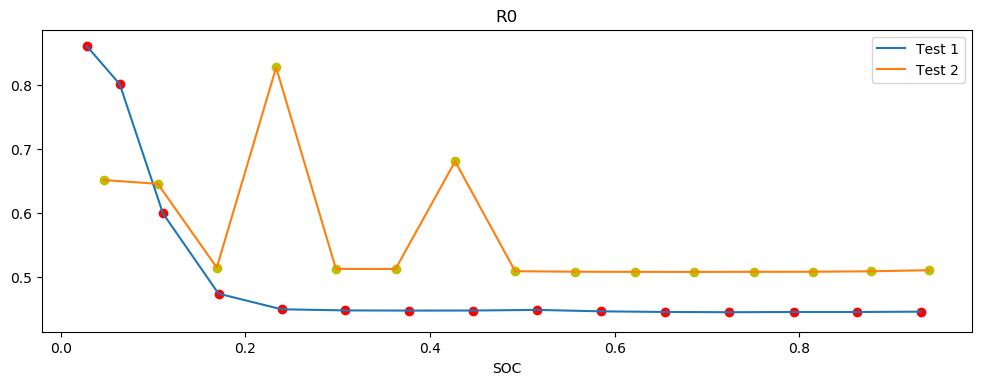

In [15]:
###### Find SOC  ##########

All_R0_Test1[2]=All_R0_Test1[1] # Bad sample replace with previous one

SOC_R0=[]
SOC_R02=[]
plt.figure(figsize=(12, 4), dpi=100)
for tt in range(15):
    SOC_R0.append(np.mean(SOC_test1[Strtidx1[tt]+1:Endidx1[tt+1]+1]))
    plt.scatter(np.mean(SOC_test1[Strtidx1[tt]+1:Endidx1[tt+1]+1]), All_R0_Test1[tt], c='r')
    SOC_R02.append(np.mean(SOC_test2[Strtidx2[tt]+1:Endidx2[tt+1]+1]))
    plt.scatter(np.mean(SOC_test2[Strtidx1[tt]+1:Endidx1[tt+1]+1]), All_R0_Test2[tt], c='y')

xsoc=(np.array(SOC_R0))
xsoc2=(np.array(SOC_R02))
plt.plot(xsoc,All_R0_Test1, label='Test 1')
plt.plot(xsoc2,All_R0_Test2, label='Test 2')
plt.title('R0')
plt.xlabel('SOC')
plt.show
plt.legend()

## Step 4-6: Plot the Estimated Parameters

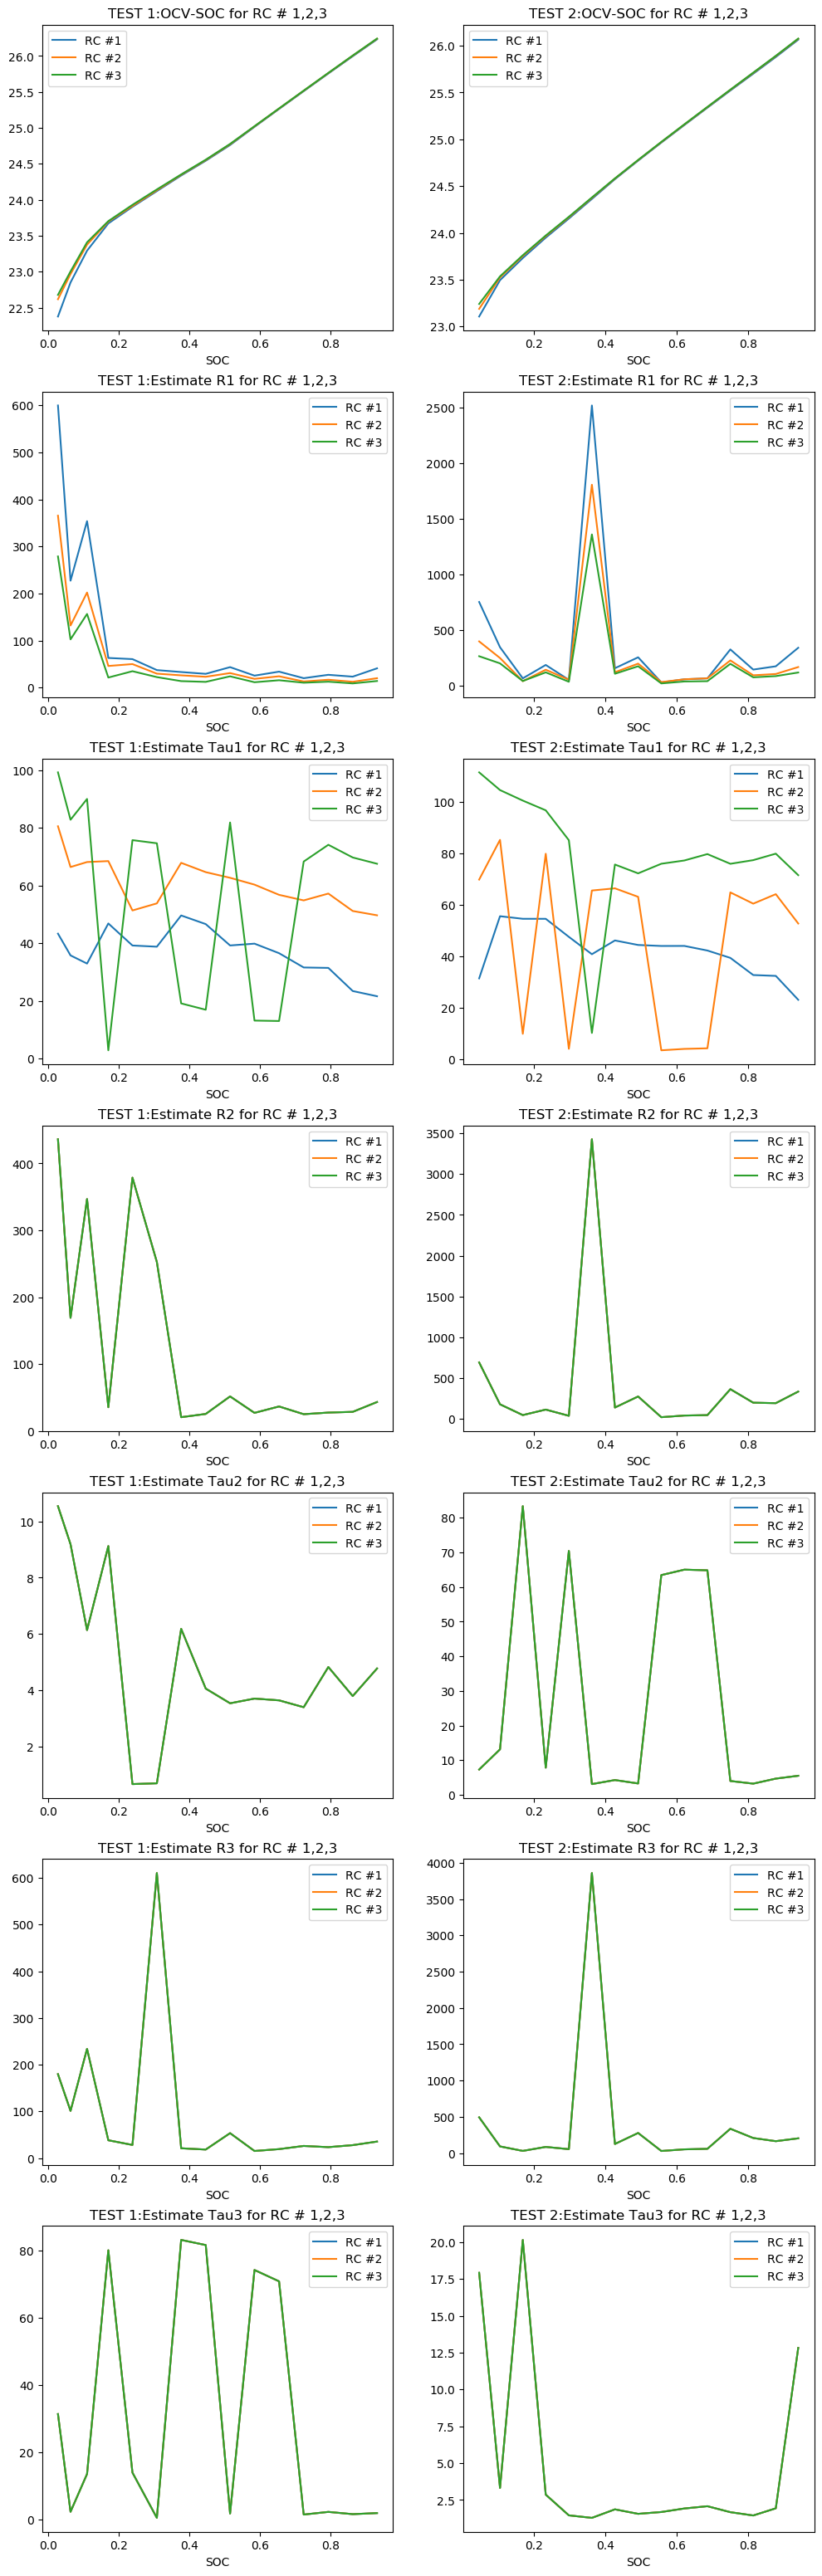

In [16]:

ocv_est1=np.zeros((len(Strtidx1)-1,1))
ocv_est2=np.zeros((len(Strtidx1)-1,1))

R1_test1=np.zeros((len(Strtidx1)-1,1))
Tau1_test1=np.zeros((len(Strtidx1)-1,1))

R1_test2=np.zeros((len(Strtidx1)-1,1))
Tau1_test2=np.zeros((len(Strtidx1)-1,1))

R2_test1=np.zeros((len(Strtidx1)-1,1))
Tau2_test1=np.zeros((len(Strtidx1)-1,1))

R2_test2=np.zeros((len(Strtidx1)-1,1))
Tau2_test2=np.zeros((len(Strtidx1)-1,1))

R3_test1=np.zeros((len(Strtidx1)-1,1))
Tau3_test1=np.zeros((len(Strtidx1)-1,1))

R3_test2=np.zeros((len(Strtidx1)-1,1))
Tau3_test2=np.zeros((len(Strtidx1)-1,1))

Title=['OCV-SOC ', 'OCV-SOC ','Estimate R1 ','Estimate R1 ','Estimate Tau1 ','Estimate Tau1 ','Estimate R2 ','Estimate R2 ','Estimate Tau2 ','Estimate Tau2 ','Estimate R3 ','Estimate R3 ','Estimate Tau3 ','Estimate Tau3 ']
plt.figure(figsize=(12, 40), dpi=100)
for fig_plt in range(14):
    plt.subplot(7,2,fig_plt+1) 
    if (fig_plt % 2) == 0:
        plt.title('TEST 1:'+Title[fig_plt]+ 'for RC # 1,2,3')
    else:
        plt.title('TEST 2:'+Title[fig_plt]+ 'for RC # 1,2,3')
        
    plt.xlabel('SOC');

    for xpn in range(3):
        for nn in range(len(Strtidx1)-1):
            ocv_est1[nn]= EstParam_data1[nn][xpn].x[0]
            ocv_est2[nn]= EstParam_data2[nn][xpn].x[0]
            
            R1_test1[nn]= EstParam_data1[nn][xpn].x[1]
            R1_test2[nn]=np.abs(EstParam_data2[nn][xpn].x[1])
            
            Tau1_test1[nn]= EstParam_data1[nn][xpn].x[2]
            Tau1_test2[nn]=np.abs(EstParam_data2[nn][xpn].x[2])
            
            if xpn==1:
                R1_test1[nn]= EstParam_data1[nn][xpn].x[1]
                R1_test2[nn]=np.abs(EstParam_data2[nn][xpn].x[1])
            
                Tau1_test1[nn]= EstParam_data1[nn][xpn].x[2]
                Tau1_test2[nn]=np.abs(EstParam_data2[nn][xpn].x[2])
                
                R2_test1[nn]= EstParam_data1[nn][xpn].x[3]
                R2_test2[nn]=np.abs(EstParam_data2[nn][xpn].x[3])
            
                Tau2_test1[nn]= EstParam_data1[nn][xpn].x[4]
                Tau2_test2[nn]=np.abs(EstParam_data2[nn][xpn].x[4])            

                
            if xpn==2:
                
                R3_test1[nn]= EstParam_data1[nn][xpn].x[5]
                R3_test2[nn]=np.abs(EstParam_data2[nn][xpn].x[5])
            
                Tau3_test1[nn]= EstParam_data1[nn][xpn].x[6]
                Tau3_test2[nn]=np.abs(EstParam_data2[nn][xpn].x[6]) 
                
        if fig_plt==0:
            plt.plot(xsoc,ocv_est1, label='RC #'+str(xpn+1))
            plt.legend()
        if fig_plt==1:
            plt.plot(xsoc2,ocv_est2, label='RC #'+str(xpn+1))
            plt.legend()  
        if fig_plt==2:
            plt.plot(xsoc,R1_test1, label='RC #'+str(xpn+1))
            plt.legend()
        if fig_plt==3:
            plt.plot(xsoc2,R1_test2, label='RC #'+str(xpn+1))
            plt.legend()
        if fig_plt==4:
            plt.plot(xsoc,Tau1_test1, label='RC #'+str(xpn+1))
            plt.legend()
        if fig_plt==5:
            plt.plot(xsoc2,Tau1_test2, label='RC #'+str(xpn+1))
            plt.legend()
        if fig_plt==6:
            plt.plot(xsoc,R2_test1, label='RC #'+str(xpn+1))
            plt.legend()
        if fig_plt==7:
            plt.plot(xsoc2,R2_test2, label='RC #'+str(xpn+1))
            plt.legend()
        if fig_plt==8:
            plt.plot(xsoc,Tau2_test1, label='RC #'+str(xpn+1))
            plt.legend()
        if fig_plt==9:
            plt.plot(xsoc2,Tau2_test2, label='RC #'+str(xpn+1))
            plt.legend()
        if fig_plt==10:
            plt.plot(xsoc,R3_test1, label='RC #'+str(xpn+1))
            plt.legend()
        if fig_plt==11:
            plt.plot(xsoc2,R3_test2, label='RC #'+str(xpn+1))
            plt.legend()
        if fig_plt==12:
            plt.plot(xsoc,Tau3_test1, label='RC #'+str(xpn+1))
            plt.legend()
        if fig_plt==13:
            plt.plot(xsoc2,Tau3_test2, label='RC #'+str(xpn+1))
            plt.legend()